In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

%load_ext autoreload
%autoreload 2

# Dataset 1A

In [2]:
# ### Importing the train, test and cross validation data set
col_names = ["x1","x2","y"]

## Train data
data1a = pd.read_csv("../datasets/1A/train.csv",names=col_names)
display(data1a.head())

## Splitting the columns of train data
X1train = data1a["x1"]
X2train = data1a["x2"]
Ytrain = np.array(data1a["y"])
Xtrain = np.array(data1a.drop("y", axis=1))

## group labels 
classes = data1a["y"].unique()
classes

## Importing the test and cross-validation data
data1a_dev = pd.read_csv("../datasets/1A/dev.csv", names=col_names)

,x1,x2,y
0,-7.811425,1.910665,1.0
1,-0.856640,-9.639107,3.0
2,2.885077,4.785598,0.0
3,-1.405758,-7.364262,3.0
4,0.044472,-8.998423,3.0


In [3]:
## Function to split a given dataset into test and cross-validation
def create_datasets(data,cv_size):
    data.sample(frac=1).reset_index(drop=True)
    data_cv = data[0:cv_size]
    data_test = data[cv_size:]
    return data_cv,data_test

def euclidean(p1,p2):
    d = np.linalg.norm(np.array(p1)-np.array(p2))
    return d

def accuracy(y_pred,y_actual):
    true_count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_actual[i]:
            true_count += 1;
    return true_count/len(y_pred)

In [4]:
## Splitting in the ratio 70:30 (cv:test)
data1a_cv,data1a_test = create_datasets(data1a_dev,84)

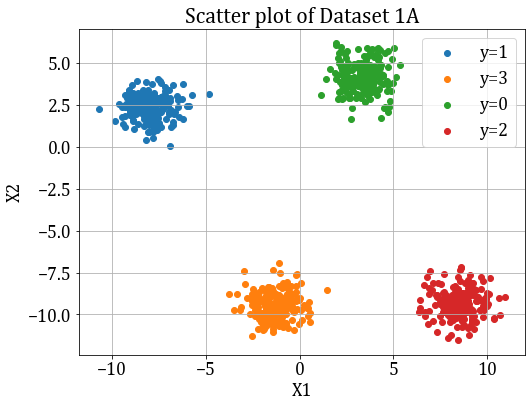

In [5]:
# ### Plotting the train data set
X_cv = np.array(data1a_cv.drop("y", axis=1))
Y_cv = np.array(data1a_cv["y"])
X_test = np.array(data1a_test.drop("y", axis=1))
Y_test = np.array(data1a_test["y"])

plt.figure()
for i in classes:
    plt.scatter(X1train[Ytrain==i],X2train[Ytrain==i],label="y="+str(int(i)))
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter plot of Dataset 1A")
plt.savefig("images/data1A_scatter.png")
plt.show()

## K Nearest Neighbour Classifier

In [6]:
def knn(x,y,test,k):
    distances = []
    for i in range(len(x)):
        d = euclidean(x[i],test)
        l = (d,x[i],y[i])
        distances.append(l)
    distances.sort(key=lambda x:x[0])
    count = Counter()
    for i in distances[:k]:
        count[i[2]] += 1
    pred = count.most_common(1)[0][0]
    
    return distances[:k], pred

In [7]:
# ### KNN on given cross-validation and test datasets:
k_list = [1,7,15]
Accuracy_cv = []
Accuracy_train = []
Accuracy_test = []

## iterating over k-values
for i in k_list:
    ycv_pred = []
    for j in X_cv:
        ycv_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    ytest_pred = []
    for j in X_test:
        ytest_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    ytrain_pred = []
    for j in Xtrain:
        ytrain_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    Accuracy_cv.append(accuracy(Y_cv, ycv_pred))
    Accuracy_test.append(accuracy(Y_test, ytest_pred))
    Accuracy_train.append(accuracy(Ytrain, ytrain_pred))

accuracy_table_knn = pd.DataFrame(list(zip(k_list, Accuracy_train, Accuracy_cv, Accuracy_test)),columns=["k-value", "Accuracy train", "Accuracy CV", "Accuracy test"])
accuracy_table_knn

,k-value,Accuracy train,Accuracy CV,Accuracy test
0,1,1.0,1.0,1.0
1,7,1.0,1.0,1.0
2,15,1.0,1.0,1.0


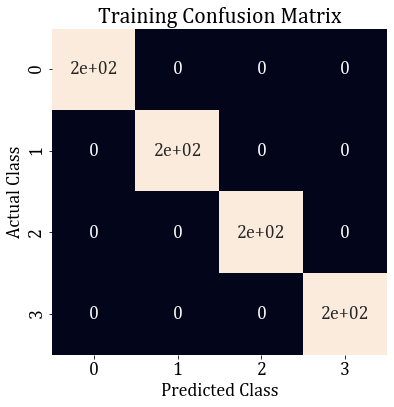

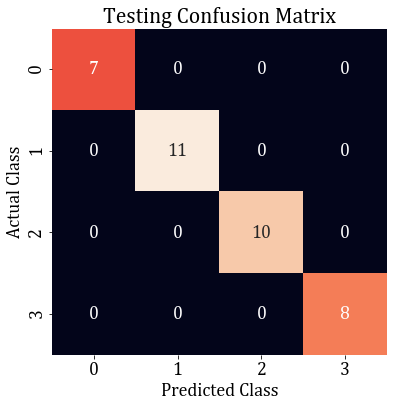

In [8]:
cm = confusion_matrix(Ytrain, ytrain_pred, labels=[1.0,3.0,0.0,2.0])
plt.figure(figsize=[6,6])
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("images/1A_cm_knn_train.png")
plt.show()

cm2 = confusion_matrix(Y_test, ytest_pred)
plt.figure(figsize=[6,6])
sns.heatmap(cm2, annot=True, cbar=False)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("images/1A_cm_knn_test.png")
plt.show()

## Naive Bayes Classifier

In [9]:

def seperate_by_classval(data):
    ## the target variable must be stored in a column named "y"
    class_vals = list(data["y"].unique())
    seperated = dict()
    features = data.drop('y',axis=1)
    Y = np.array(data["y"])
    ## creates a key value corresponding to each class label
    for i in class_vals:
        seperated[i] = features[Y==i];
    return(seperated)

def priori(data):
    seperated_data = seperate_by_classval(data)
    probs = dict()
    for i in seperated_data.keys():
        probs[i] = len(seperated_data[i])/len(data);
    return probs

def mu_sigma(data):
    seperated_data = seperate_by_classval(data)
    mean = dict()
    sigma = {}
    for i in list(seperated_data.keys()):
        features = seperated_data[i]
        mean[i] = []
        sigma[i] = []
        for j in range(seperated_data[i].shape[1]):
            mean[i].append(np.mean(features.iloc[:,j]))
            sigma[i].append(np.std(features.iloc[:,j]))
    return(mean,sigma)  

def gauss_val(x,cov_matrix,mean):
    x = np.array(x)
    A = (x-mean)
    B = np.linalg.inv(cov_matrix)
    C = np.transpose(A)
    det = np.linalg.det(cov_matrix)
    AB = A.dot(B)
    m = AB.dot(C)
    
    exp_term = np.exp(-m/2)
    d = 2
    return (exp_term/(2*np.pi*det**0.5))

In [10]:
## Seperating the data according to class label:
seperated_data = seperate_by_classval(data1a)

### Labels: 
labels = list(data1a["y"].unique())

### Initiating the accuracy table
accuracy_table_bayes = pd.DataFrame()
accuracy_table_bayes["method"] = ["Ci=Cj=sigma**2*I","Ci=Cj=C","Ci!=Cj"]

accuracy_table_bayes["Train Accuracy"]=[0,0,0]
accuracy_table_bayes["CV accuracy"]=[0,0,0]
accuracy_table_bayes["Test Accuracy"]=[0,0,0]

In [11]:
### Case 1: Ci=Cj=sigma**2 * I
sigma = mu_sigma(data1a)[1]
print(sigma)

var = 0
for i in labels:
    var += sigma[i][0]**2+sigma[i][1]**2
    
var = var/(4*2)

{1.0: [0.8529220437179766, 0.72154911050952], 3.0: [0.8376269083469755, 0.7864905414985229], 0.0: [0.8200768047613737, 0.8835371049714199], 2.0: [0.8736650746983485, 0.8171549339311917]}


In [12]:
def predictor1(x):
    pyi_x = {}
    pyi = priori(data1a)
    means = mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i] = pyi[i]*gauss_val(x,var*np.eye(2),means[i])
    val = sum(pyi_x.values())
    p = 0
    for i in labels:
        pyi_x[i] /= val
        if pyi_x[i]>p:
            prediction = i
            p = pyi_x[i]

    return pyi_x, prediction

In [13]:
predictor1([-10,5])

Y_nb1_cv = []
Y_nb1_test = []
Y_nb1_train = []
for i in range(len(X_cv)):
    Y_nb1_cv.append(predictor1(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb1_test.append(predictor1(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb1_train.append(predictor1(Xtrain[i])[1])
    

accuracy_table_bayes.iloc[0,1:] = [accuracy(Y_nb1_train, Ytrain), accuracy(Y_nb1_cv, Y_cv), accuracy(Y_nb1_test, Y_test)]

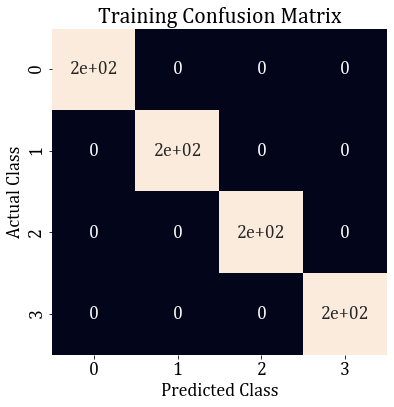

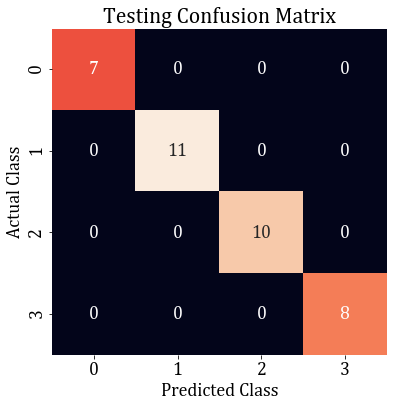

In [14]:
### Confusion Matrix
cm_nb_train = confusion_matrix(Y_nb1_train,Ytrain)
plt.figure(figsize=[6,6])
sns.heatmap(cm_nb_train, annot=True, cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("images/1A_cm_nb_train.png")
plt.show()

cm_nb_test = confusion_matrix(Y_nb1_test,Y_test)
plt.figure(figsize=[6,6])
sns.heatmap(cm_nb_test, annot=True, cbar=False)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("images/1A_cm_nb_test.png")
plt.show()

<Figure size 576x432 with 0 Axes>

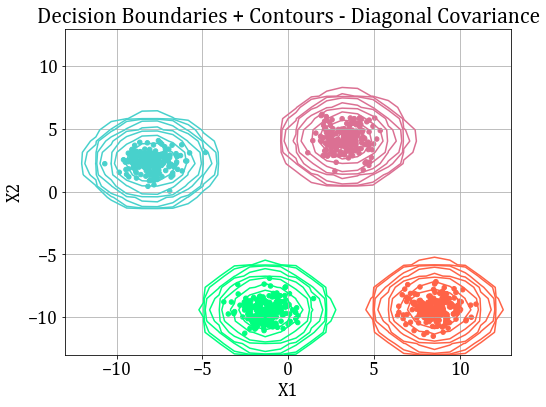

In [15]:
### level curves:
x, y = np.mgrid[-13:13:30j, -13:13:30j]
xy = np.column_stack([x.flat, y.flat])

mu = mu_sigma(data1a)
z0 = np.zeros(len(xy))
z1 = np.zeros(len(xy))
z2 = np.zeros(len(xy))
z3 = np.zeros(len(xy))

for i in range(len(xy)):
    z0[i] = gauss_val(xy[i],var*np.eye(2),mu[0][0])
    z1[i] = gauss_val(xy[i],var*np.eye(2),mu[0][1])
    z2[i] = gauss_val(xy[i],var*np.eye(2),mu[0][2])
    z3[i] = gauss_val(xy[i],var*np.eye(2),mu[0][3])

z0 = z0.reshape(x.shape)
z1 = z1.reshape(x.shape)
z2 = z2.reshape(x.shape)
z3 = z3.reshape(x.shape)

color_list = ["palevioletred", "mediumturquoise", "tomato", "springgreen"]
plt.figure()
data1a.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1a["y"]], alpha=1)
plt.contour(x, y, z0, levels=np.logspace(-5,5,20), colors=color_list[0])
plt.contour(x, y, z1, levels=np.logspace(-5,5,20), colors=color_list[1])
plt.contour(x, y, z2, levels=np.logspace(-5,5,20), colors=color_list[2])
plt.contour(x, y, z3, levels=np.logspace(-5,5,20), colors=color_list[3])

plt.title("Decision Boundaries + Contours - Diagonal Covariance")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig("images/1A_contour_case1.png")
plt.show()

In [16]:
### Case 2: Covariance matrix is same for all the classes:
cov_matrix = {}
for i in labels:
    cov_matrix[i] = np.cov(seperated_data[i],rowvar=False)  

C = np.zeros((2,2))
for i in labels:
    C += cov_matrix[i]
C /= 4

In [17]:
def predictor2(x):
    pyi_x = {}
    pyi = priori(data1a)
    means = mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i] = pyi[i]*gauss_val(x,C,means[i])
    val = sum(pyi_x.values())
    p = 0
    for i in labels:
        pyi_x[i] /= val
        if pyi_x[i]>p:
            prediction = i
            p = pyi_x[i]
    
    return pyi_x, prediction

In [18]:
Y_nb2_cv = []
Y_nb2_test = []
Y_nb2_train = []
for i in range(len(X_cv)):
    Y_nb2_cv.append(predictor2(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb2_test.append(predictor2(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb2_train.append(predictor2(Xtrain[i])[1])
    
accuracy_table_bayes.iloc[1,1:] = [accuracy(Y_nb2_train,Ytrain),accuracy(Y_nb2_cv,Y_cv),accuracy(Y_nb2_test,Y_test)]

<Figure size 576x432 with 0 Axes>

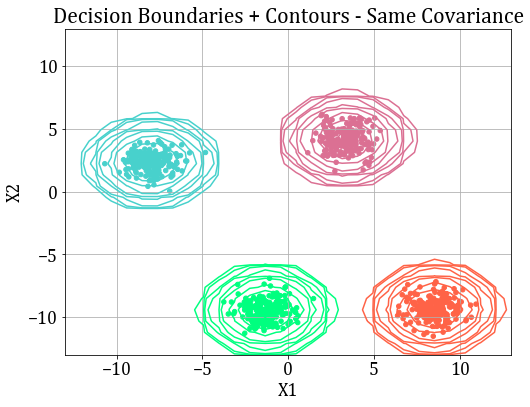

In [19]:
### level curves
x, y = np.mgrid[-13:13:30j, -13:13:30j]
xy = np.column_stack([x.flat, y.flat])
z0 = np.zeros(len(xy))
z1 = np.zeros(len(xy))
z2 = np.zeros(len(xy))
z3 = np.zeros(len(xy))

for i in range(len(xy)):
    z0[i] = gauss_val(xy[i],C,mu[0][0])
    z1[i] = gauss_val(xy[i],C,mu[0][1])
    z2[i] = gauss_val(xy[i],C,mu[0][2])
    z3[i] = gauss_val(xy[i],C,mu[0][3])

z0 = z0.reshape(x.shape)
z1 = z1.reshape(x.shape)
z2 = z2.reshape(x.shape)
z3 = z3.reshape(x.shape)

plt.figure()
data1a.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1a["y"]], alpha=1)
plt.contour(x, y, z0, levels=np.logspace(-5,5,20), colors=color_list[0])
plt.contour(x, y, z1, levels=np.logspace(-5,5,20), colors=color_list[1])
plt.contour(x, y, z2, levels=np.logspace(-5,5,20), colors=color_list[2])
plt.contour(x, y, z3, levels=np.logspace(-5,5,20), colors=color_list[3])
plt.title("Decision Boundaries + Contours - Same Covariance")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig("images/1A_contour_case2.png")
plt.show()

In [20]:
####  Case 3: Covariance matrix is different for all the classes: 
def predictor3(x):
    pyi_x={}
    pyi=priori(data1a)
    means=mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i]=pyi[i]*gauss_val(x,cov_matrix[i],means[i])
    val=sum(pyi_x.values())
    p=0
    for i in labels:
        pyi_x[i]/=val
        if pyi_x[i]>p:
            prediction=i
            p=pyi_x[i]
        
    
    return(pyi_x,prediction)
        
predictor3([5,5])

({1.0: 8.88246479902385e-52,
  3.0: 3.2747719897152533e-82,
  0.0: 1.0,
  2.0: 6.867533640103264e-70},
 0.0)

In [21]:
Y_nb3_cv=[]
Y_nb3_test=[]
Y_nb3_train=[]
for i in range(len(X_cv)):
    Y_nb3_cv.append(predictor3(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb3_test.append(predictor3(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb3_train.append(predictor3(Xtrain[i])[1])
    
accuracy_table_bayes.iloc[2,1:]=[accuracy(Y_nb3_train,Ytrain),accuracy(Y_nb3_cv,Y_cv),accuracy(Y_nb3_test,Y_test)]
accuracy_table_bayes

,method,Train Accuracy,CV accuracy,Test Accuracy
0,Ci=Cj=sigma**2*I,1.0,1.0,1.0
1,Ci=Cj=C,1.0,1.0,1.0
2,Ci!=Cj,1.0,1.0,1.0


<Figure size 576x432 with 0 Axes>

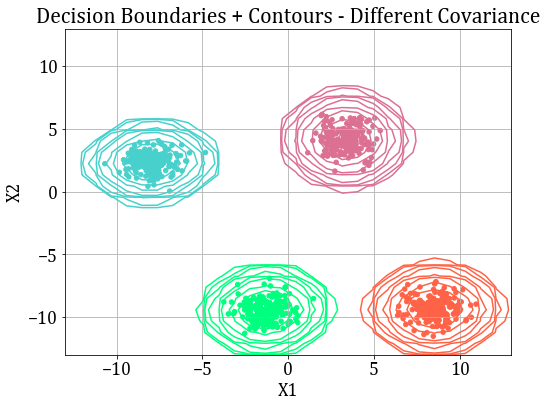

In [22]:
x, y = np.mgrid[-13:13:30j, -13:13:30j]
xy = np.column_stack([x.flat, y.flat])
z0 = np.zeros(len(xy))
z1 = np.zeros(len(xy))
z2 = np.zeros(len(xy))
z3 = np.zeros(len(xy))

for i in range(len(xy)):
    z0[i] = gauss_val(xy[i],cov_matrix[0],mu[0][0])
    z1[i] = gauss_val(xy[i],cov_matrix[1],mu[0][1])
    z2[i] = gauss_val(xy[i],cov_matrix[2],mu[0][2])
    z3[i] = gauss_val(xy[i],cov_matrix[3],mu[0][3])

z0 = z0.reshape(x.shape)
z1 = z1.reshape(x.shape)
z2 = z2.reshape(x.shape)
z3 = z3.reshape(x.shape)

plt.figure()
data1a.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1a["y"]], alpha=1)
plt.contour(x, y, z0, levels=np.logspace(-5,5,20), colors=color_list[0])
plt.contour(x, y, z1, levels=np.logspace(-5,5,20), colors=color_list[1])
plt.contour(x, y, z2, levels=np.logspace(-5,5,20), colors=color_list[2])
plt.contour(x, y, z3, levels=np.logspace(-5,5,20), colors=color_list[3])

plt.title("Decision Boundaries + Contours - Different Covariance")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig("images/1A_contour_case3.png")
plt.show()

In [23]:
#### Decision boundary plot for knn:
min1, max1 = data1a["x1"].min()-1, data1a["x1"].max()+1
min2, max2 = data1a["x2"].min()-1, data1a["x2"].max()+1

resolution = 0.5
x1grid = np.arange(min1, max1, resolution)
x2grid = np.arange(min2, max2, resolution)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1, r2))

yhat_knn_1 = []
for i in range(len(grid)):
    yhat_knn_1.append(knn(Xtrain, Ytrain, grid[i,:],1)[1])

len(grid)
yhat_knn_1 = np.array(yhat_knn_1)
zz = yhat_knn_1.reshape(xx.shape)
data1a["y"].unique()

array([1., 3., 0., 2.])

<Figure size 576x432 with 0 Axes>

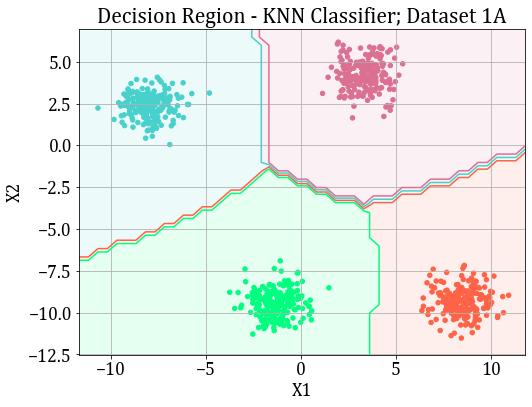

In [24]:
plt.figure()
data1a.sort_values(by=["y"], ascending=True, inplace=True)
data1a.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1a["y"]], alpha=1)
plt.contourf(xx, yy, zz, 3, colors=color_list, alpha=0.1)
plt.contour(xx, yy, zz, 3, colors=color_list, alpha=1)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Region - KNN Classifier; Dataset 1A")
plt.savefig("images/1A_knn_decision_region.png")
plt.show()

<Figure size 576x432 with 0 Axes>

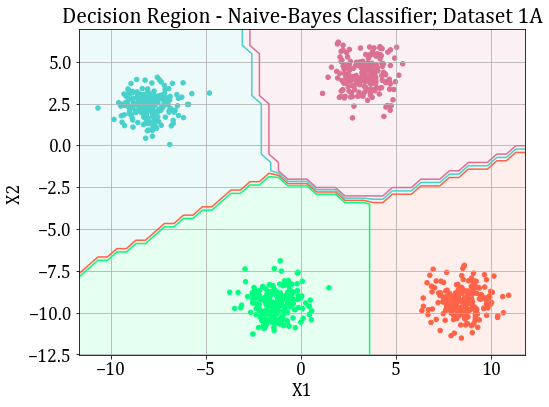

In [25]:
yhat_nb = []
for i in range(len(grid)):
    yhat_nb.append(predictor1(grid[i,:])[1])

yhat_nb = np.array(yhat_nb)
zz_nb = yhat_nb.reshape(xx.shape)

plt.figure()
data1a.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1a["y"]], alpha=1)
plt.contourf(xx, yy, zz_nb, 3, colors=color_list, alpha=0.1)
plt.contour(xx, yy, zz_nb, 3, colors=color_list, alpha=1)
plt.xlabel("X1")
plt.ylabel("X2 ")
plt.title("Decision Region - Naive-Bayes Classifier; Dataset 1A")
plt.savefig("images/1A_nb_case1_decisionregion.png")
plt.show()